In [1]:
!pip install yfinance

In [2]:
!pip install pmdarima

XGBOOST

In [3]:
!pip install xgboost

In [4]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf

#import pandas_datareader as pdr
#from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install optuna

In [6]:
stock = yf.download('AMZN') # stockticker

[*********************100%%**********************]  1 of 1 completed


In [7]:
num_days_pred = 30 # Number of days to predict in the future is inversely proportional to accuracy

In [8]:
# We will use the last 2 years of stock data 
slice = int(len(stock)- 356*2)
stock = stock.iloc[slice:]

In [9]:
# We will use only Close value column
stock.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


In [10]:
# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)  
    df['lag2'] = df[target].shift(num_days_pred*2)    
    df['lag3'] = df[target].shift(num_days_pred*3)    
    df['lag4'] = df[target].shift(num_days_pred*4)    
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [11]:
df_xgb = stock.copy()

In [12]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)
    
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [13]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }
    
    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)
    
    # Fit the model on training data
    xgb.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-25 11:30:00,949] A new study created in memory with name: no-name-34534128-c25a-4bbe-b90d-e69b1aa1e911
[I 2024-04-25 11:30:02,602] Trial 0 finished with value: 4.089911165764659 and parameters: {'n_estimators': 576, 'max_depth': 8, 'learning_rate': 0.061244720697695036, 'subsample': 0.8026811463441592, 'colsample_bytree': 0.6257477747544253, 'reg_alpha': 6.053641645717479, 'reg_lambda': 8.495688407538841}. Best is trial 0 with value: 4.089911165764659.
[I 2024-04-25 11:30:03,813] Trial 1 finished with value: 3.960085938915073 and parameters: {'n_estimators': 651, 'max_depth': 6, 'learning_rate': 0.08649795195238914, 'subsample': 0.8235464004879012, 'colsample_bytree': 0.642108657134145, 'reg_alpha': 9.140799631802853, 'reg_lambda': 2.7977190091887447}. Best is trial 1 with value: 3.960085938915073.
[I 2024-04-25 11:30:06,133] Trial 2 finished with value: 4.466773215004588 and parameters: {'n_estimators': 699, 'max_depth': 9, 'learning_rate': 0.05260771909413164, 'subsample':

[I 2024-04-25 11:30:46,471] Trial 23 finished with value: 4.310887725009563 and parameters: {'n_estimators': 751, 'max_depth': 9, 'learning_rate': 0.07840271783734147, 'subsample': 0.8701356749874721, 'colsample_bytree': 0.7185863487183871, 'reg_alpha': 7.5071737356298325, 'reg_lambda': 0.9408926046970145}. Best is trial 1 with value: 3.960085938915073.
[I 2024-04-25 11:30:48,735] Trial 24 finished with value: 4.0557492906510015 and parameters: {'n_estimators': 907, 'max_depth': 9, 'learning_rate': 0.09337299595347678, 'subsample': 0.7906806553396772, 'colsample_bytree': 0.6438942067655555, 'reg_alpha': 8.748976264818104, 'reg_lambda': 1.1542135603674295}. Best is trial 1 with value: 3.960085938915073.
[I 2024-04-25 11:30:51,279] Trial 25 finished with value: 3.8436610410993524 and parameters: {'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.08798122717396814, 'subsample': 0.8135745318985682, 'colsample_bytree': 0.6477585432522137, 'reg_alpha': 7.074391641062809, 'reg_lambda':

[I 2024-04-25 11:31:26,897] Trial 46 finished with value: 3.8701347760071916 and parameters: {'n_estimators': 534, 'max_depth': 10, 'learning_rate': 0.09612569227672026, 'subsample': 0.9738814687082145, 'colsample_bytree': 0.6546556930284114, 'reg_alpha': 3.5005788049172257, 'reg_lambda': 0.18933161175182622}. Best is trial 26 with value: 3.679005569077862.
[I 2024-04-25 11:31:28,481] Trial 47 finished with value: 4.030618513585366 and parameters: {'n_estimators': 532, 'max_depth': 9, 'learning_rate': 0.09506330448442243, 'subsample': 0.9424223583050617, 'colsample_bytree': 0.6628440825157232, 'reg_alpha': 3.4049823731601343, 'reg_lambda': 0.5290997086607807}. Best is trial 26 with value: 3.679005569077862.
[I 2024-04-25 11:31:29,628] Trial 48 finished with value: 4.019945158714024 and parameters: {'n_estimators': 288, 'max_depth': 10, 'learning_rate': 0.09466464191181853, 'subsample': 0.9835860950497932, 'colsample_bytree': 0.6871028379868197, 'reg_alpha': 3.604728018207341, 'reg_lamb

Best trial:
  Value: 3.679005569077862
  Params: 
    n_estimators: 899
    max_depth: 10
    learning_rate: 0.08953480877789233
    subsample: 0.9322682779756748
    colsample_bytree: 0.6961861458681826
    reg_alpha: 8.68206606361613
    reg_lambda: 0.047017056794062095
Test RMSE: 3.679005569077862


In [15]:
# Evaluation


y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 2.0435454960949886% 


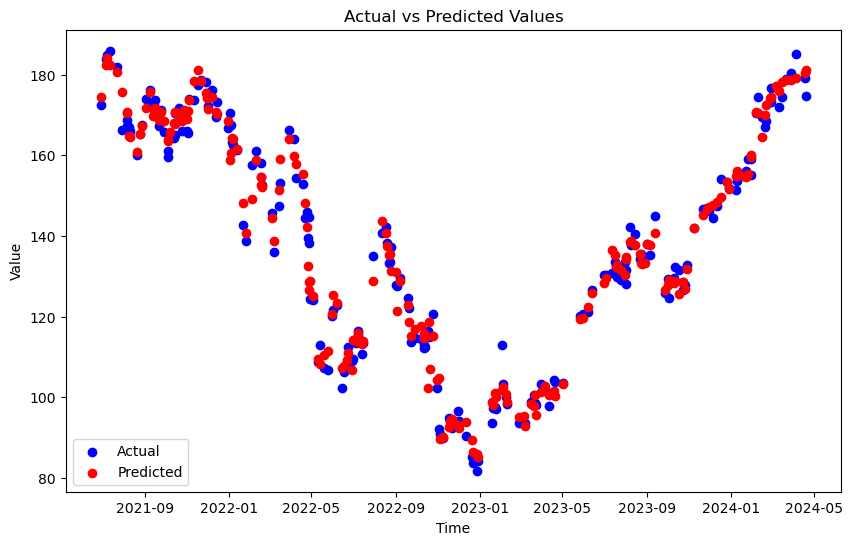

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

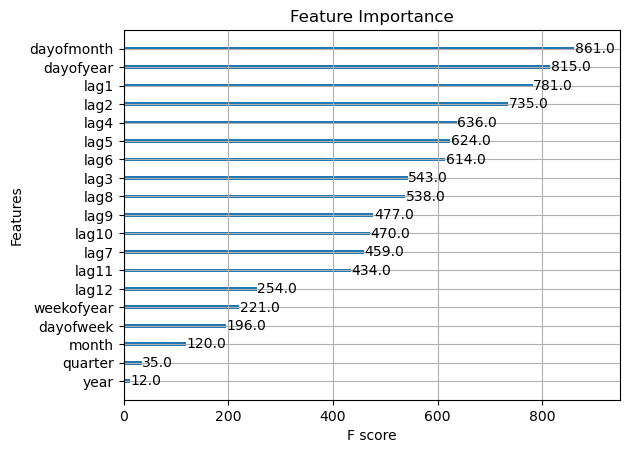

In [17]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

In [18]:
#Predict future


start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

In [19]:
future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [20]:
future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))

In [21]:
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-04-24,174.382462
2024-04-25,176.440109
2024-04-26,172.450378
2024-04-27,170.324188
2024-04-28,170.374924
2024-04-29,170.247559
2024-04-30,166.294281
2024-05-01,163.419769
2024-05-02,163.823853
2024-05-03,165.730728


ARIMA

In [22]:
df_arima = stock.copy()

In [23]:
# 80-20 split

split_date = df_arima.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

In [24]:
# Try to find the best parameters for arima model 
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2967.989, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2962.851, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2964.851, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2964.851, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2961.157, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2966.851, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.076 seconds


In [25]:
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

In [26]:
start = len(train_arima)
end = len(test_arima) + len(train_arima)

In [27]:
pred_arima = arima.predict(start=start,end=end-1)

In [28]:
pred_arima.index = test_arima.index

<Axes: xlabel='Date'>

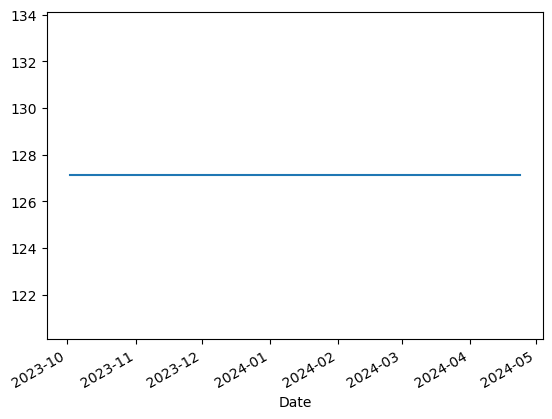

In [29]:
pred_arima.plot()

In [30]:
arima_loss = mean_absolute_percentage_error(test_arima['Close'],pred_arima )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test_arima['Close'],pred_arima ) }% ")

ERROR PERCENT = 18.087883351748197% 


In [ ]:
# best parameters for arima model 
stepwise_fit = auto_arima(df_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()

In [ ]:
start = len(df_arima)
end = len(df_arima) + num_days_pred
arima_forecast = arima.predict(start=start,end=end)

In [ ]:
start = df_arima.index.max()
end = start + pd.Timedelta(days=num_days_pred)
arima_forecast.index = pd.date_range(start, end, freq='1d')

In [ ]:
arima_forecast = pd.DataFrame(arima_forecast)

In [ ]:
fig, ax  = plt.subplots(figsize=(10,5))
arima_forecast.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
plt.legend(['Arima','XGB'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [ ]:
print(f"XGB Acc : {100-xgb_loss} \nArima Acc : {100-arima_loss}")

[*********************100%%**********************]  1 of 1 completed


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  554
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1440.499
Date:                Thu, 25 Apr 2024   AIC                           2892.997
Time:                        11:33:44   BIC                           2918.889
Sample:                             0   HQIC                          2903.113
                                - 554                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0067      0.040     -0.169      0.866      -0.085       0.071
ar.L2          0.0151      0.046      0.328      0.743      -0.075       0.105
ar.L3         -0.0191      0.040     -0.475      0.6

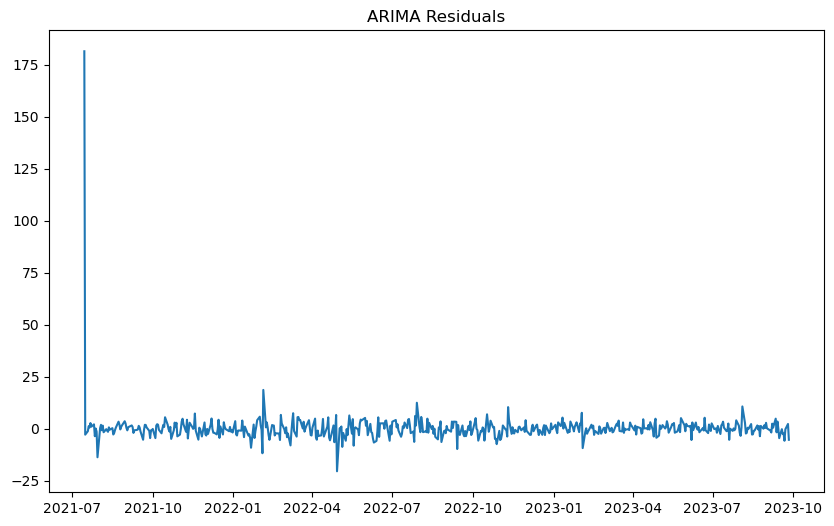

ValueError: too many values to unpack (expected 3)

In [31]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

# Downloading stock data for Amazon (AMZN)
stock = yf.download('AMZN')

# Number of days to predict in the future
num_days_pred = 30

# Slicing the data to use only the last 2 years
slice_index = -365 * 2
stock = stock.iloc[slice_index:]

# Keeping only the 'Close' price column
stock = stock[['Close']]

# Function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to add lag features
def add_lags(df, num_days_pred=num_days_pred):
    target = 'Close'
    for i in range(1, num_days_pred+1):
        df[f'lag_{i}'] = df[target].shift(i)
    return df

# Preprocessing data
stock = add_lags(stock)

# Splitting data into train and test sets
train_size = int(len(stock) * 0.8)
train, test = stock[:train_size], stock[train_size:]

# Removing missing values
train.dropna(inplace=True)
test.dropna(inplace=True)

# Define the ARIMA model
model = ARIMA(train['Close'], order=(5,1,0))

# Fit the ARIMA model
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())

# Plotting residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('ARIMA Residuals')
plt.show()

# Making predictions on the test set
predictions, _, _ = model_fit.forecast(steps=len(test))

# Calculating evaluation metrics
mae = mean_absolute_error(test['Close'], predictions)
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Close'], predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)


In [32]:
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t', key, ':', value)

# Check stationarity of the original time series
print("Stationarity Test for Original Time Series:")
adf_test(df_arima['Close'])

# Check stationarity after differencing
print("\nStationarity Test after Differencing:")
adf_test(df_arima['Close'].diff().dropna())


Stationarity Test for Original Time Series:
ADF Statistic: -1.3615827649568244
p-value: 0.6005490527002617
Critical Values:
	 1% : -3.439580754053961
	 5% : -2.865613606467485
	 10% : -2.568939269723711

Stationarity Test after Differencing:
ADF Statistic: -26.646077108218854
p-value: 0.0
Critical Values:
	 1% : -3.439593802573824
	 5% : -2.865619356068967
	 10% : -2.568942332870462


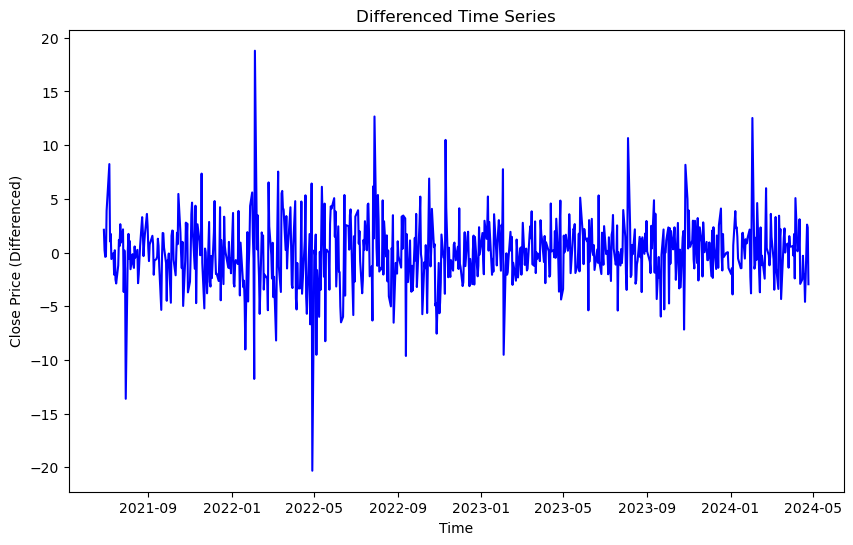

In [33]:
# Differencing the original time series
df_arima['Close_differenced'] = df_arima['Close'].diff()

# Plotting the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(df_arima.index, df_arima['Close_differenced'], color='blue')
plt.title('Differenced Time Series')
plt.xlabel('Time')
plt.ylabel('Close Price (Differenced)')
plt.show()


In [34]:
# Check stationarity of the differenced time series
print("Stationarity Test after Differencing:")
adf_test(df_arima['Close_differenced'].dropna())


Stationarity Test after Differencing:
ADF Statistic: -26.646077108218854
p-value: 0.0
Critical Values:
	 1% : -3.439593802573824
	 5% : -2.865619356068967
	 10% : -2.568942332870462


The p-value is less than 0.05, which indicates that the null hypothesis of non-stationarity is rejected. Therefore, we can conclude that the differenced time series is stationary.

You can now proceed with modeling using the stationary time series data. This may include fitting an ARIMA model or other time series forecasting techniques.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  570
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1479.426
Date:                Thu, 25 Apr 2024   AIC                           2962.851
Time:                        11:33:59   BIC                           2971.539
Sample:                             0   HQIC                          2966.241
                                - 570                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0755      0.137     -0.551      0.581      -0.344       0.193
sigma2        10.6144      0.331     32.054      0.000       9.965      11.263
Ljung-Box (L1) (Q):                   0.00   Jarque-

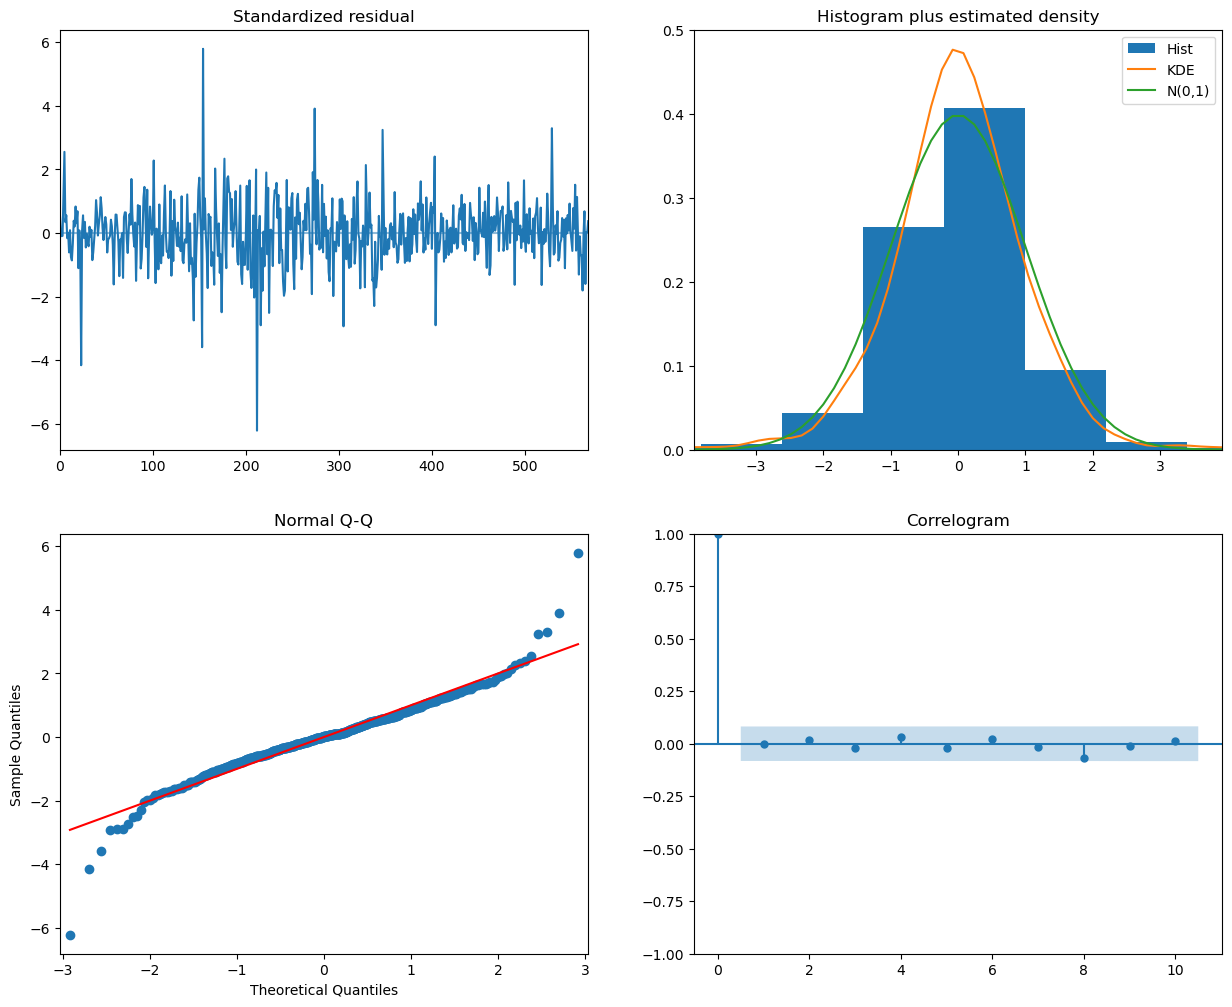

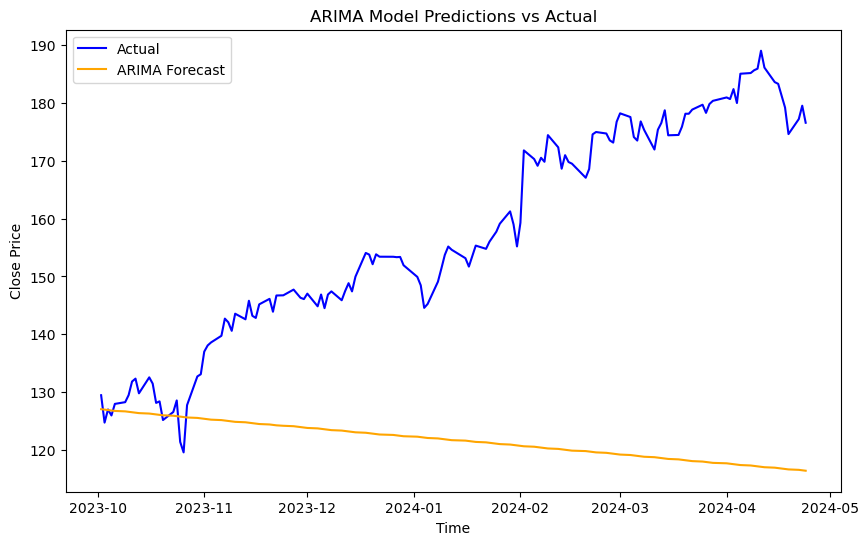

In [35]:
from pmdarima import auto_arima, ARIMA

# Fit ARIMA model with best parameters
model_arima = ARIMA(order=(0, 1, 0))
model_arima_fit = model_arima.fit(train_arima['Close'])

# Summary of the ARIMA model
print(model_arima_fit.summary())

# Plot residuals
model_arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Make predictions on test data
arima_forecast = model_arima_fit.predict(n_periods=len(test_arima))

# Plot ARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(test_arima.index, test_arima['Close'], color='blue', label='Actual')
plt.plot(test_arima.index, arima_forecast, color='orange', label='ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.title('ARIMA Model Predictions vs Actual')
plt.show()


In [36]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
arima_mape = mean_absolute_percentage_error(test_arima['Close'], arima_forecast)
print(f"MAPE for ARIMA: {arima_mape}%")


MAPE for ARIMA: 21.28507675405618%
